In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
material_1 = pd.read_excel('F:/00程序/Githubclone_Projects/ICNN/datasets/CoreLosses/附件一（训练集）.xlsx', sheet_name='材料1')
material_2 = pd.read_excel('F:/00程序/Githubclone_Projects/ICNN/datasets/CoreLosses/附件一（训练集）.xlsx', sheet_name='材料2')
material_3 = pd.read_excel('F:/00程序/Githubclone_Projects/ICNN/datasets/CoreLosses/附件一（训练集）.xlsx', sheet_name='材料3')
material_4 = pd.read_excel('F:/00程序/Githubclone_Projects/ICNN/datasets/CoreLosses/附件一（训练集）.xlsx', sheet_name='材料4')
combined_material = pd.concat([material_1, material_2, material_3, material_4], axis=0, ignore_index=True)

In [3]:
# 标签
combined_material_label = np.zeros(combined_material.shape[0])

for i in range(combined_material.shape[0]):
    if combined_material.iloc[i,3] == '正弦波':
        combined_material_label[i] = 1
    elif combined_material.iloc[i,3] == '三角波':
        combined_material_label[i] = 2
    elif combined_material.iloc[i,3] == '梯形波':
        combined_material_label[i] = 3
combined_material_label = combined_material_label.astype(int)
combined_material_label

array([1, 1, 1, ..., 3, 3, 3])

In [4]:
y = combined_material.iloc[:,2]

# temperature
T = combined_material.iloc[:,0]
# frequency
f = combined_material.iloc[:,1]
# wave type
W = combined_material_label
# material type
M = np.empty(12400, dtype=int)
# 填充 M 列
M[:3400] = 1
M[3400:6400] = 2
M[6400:9600] = 3
M[9600:] = 4

# 进行独热编码
encoder = OneHotEncoder(sparse_output=False)
W_encoded = encoder.fit_transform(W.reshape(-1, 1))
M_encoded = encoder.fit_transform(M.reshape(-1, 1))

X = np.column_stack((T, f, W_encoded, M_encoded))
X

array([[2.5000e+01, 5.0030e+04, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.5000e+01, 5.0020e+04, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.5000e+01, 5.0020e+04, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [9.0000e+01, 1.9919e+05, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [9.0000e+01, 1.9919e+05, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [9.0000e+01, 1.9919e+05, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00]])

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [6]:
xgb_model = xgb.XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [150, 100, 300],
    'max_depth': [4, 5, 6, 7],
    'learning_rate': [0.1, 0.13, 0.15, 0.17, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=150, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsampl

In [7]:
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"Train MSE: , {mse_train:.2f}")
print(f"Test MSE: , {mse_test:.2f}")
print(f"Test MAE: , {mae_test:.2f}")

Train MSE: , 121705976152.10
Test MSE: , 120097124522.14
Test MAE: , 214668.62


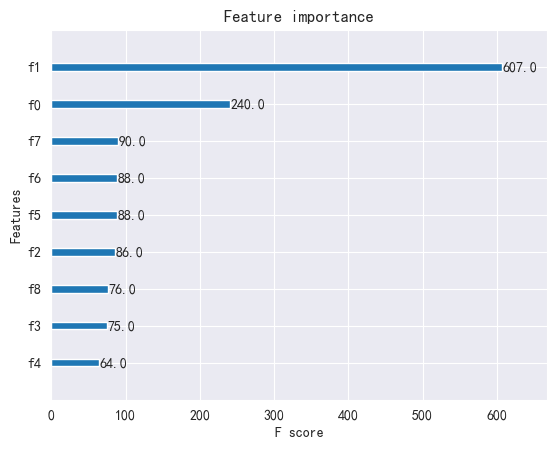

In [8]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
xgb.plot_importance(best_model)
plt.show()